In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import deepmatcher as dm
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
from utils.distance_measures import calculate_nearest_neighbors_onAttributes
import pandas as pd

In [4]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']

## Hybrid

### Datasets creation

In [6]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/itunes_amazon_hybrid.pth')
hybrid_model = hybrid_model.cuda()

In [7]:
negatives,neg_ids = return_layer_input('../../Structured/itunes-amazon','negatives',128,hybrid_model,
                                                                        hybrid_model.classifier)

In [9]:
positives,pos_ids = return_layer_input('../../Structured/itunes-amazon/',
                                                                       'positives',128,hybrid_model,
                                                                       hybrid_model.classifier)

### Negative sample analysis

In [10]:
classifier_len_hybrid = len(negatives[0][0])
attribute_len_hybrid = int(classifier_len_hybrid/len(attributes))

In [11]:
negatives_ri,neg_ri_norms= computeRi(hybrid_model.classifier,
                                                    attributes,negatives,attribute_len_hybrid,1)

100%|██████████| 128/128 [00:24<00:00,  5.17it/s]


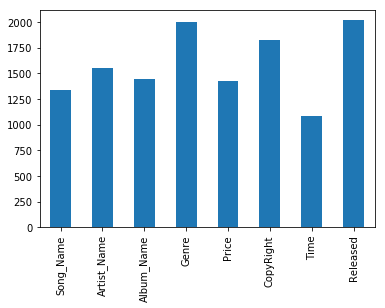

In [13]:
neg_variation_df = pd.DataFrame(data= neg_ri_norms,columns=attributes)
neg_variation_df.sum().plot.bar()

In [14]:
neg_variation_df.to_csv('experiments/results/negatives_ri_hybrid.csv',index=False)

## Positive samples analisys

In [14]:
pos_ri_hybrid,pos_ri_norms_hybrid = computeRi(hybrid_model.classifier,attributes,
                                              positives,attribute_len_hybrid,0)

100%|██████████| 128/128 [00:35<00:00,  3.62it/s]


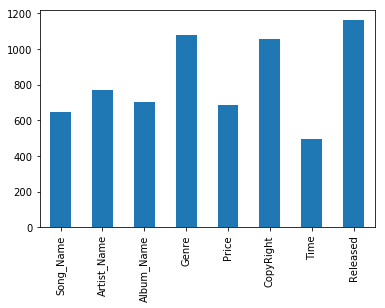

In [15]:
pos_variation_df = pd.DataFrame(data= pos_ri_norms_hybrid,columns=attributes)
pos_variation_df.sum().plot.bar()

In [17]:
pos_variation_df.to_csv('experiments/results/positives_ri_hybrid.csv',index=False)

## Nearest neighbors hybrid

In [19]:
train_neg,train_neg_ids = return_layer_input('../../Structured/itunes-amazon','train_negatives',128,hybrid_model,
                                             hybrid_model.classifier)
train_pos,train_pos_ids = return_layer_input('../../Structured/itunes-amazon/','train_positives',128,hybrid_model,
                                            hybrid_model.classifier)

In [20]:
positives_nn_hybrid = calculate_nearest_neighbors_onAttributes(positives,pos_ids,pos_ri_hybrid,
                                                       train_neg,train_neg_ids,attributes,
                                                               attribute_len_hybrid)

100%|██████████| 128/128 [00:00<00:00, 210.45it/s]


In [21]:
negatives_nn_hybrid = calculate_nearest_neighbors_onAttributes(negatives,neg_ids,negatives_ri,
                                                        train_pos,train_pos_ids,
                                                        attributes,attribute_len_hybrid)

100%|██████████| 128/128 [00:00<00:00, 234.72it/s]


In [22]:
positives_nn_hybrid.to_csv('experiments/results/positives_nn_hybrid_withoutfilter.csv',index=False)
negatives_nn_hybrid.to_csv('experiments/results/negatives_nn_hybrid_withoutfilter.csv',index=False)